https://www.randpy.tokyo/entry/python_random_forest

###1.決定木（精度、木の可視化)

###2.ランダムフォレスト(精度、重要度のプロット）

###3.番外編(kaggle式の前処理をした上での精度比較)


In [ ]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas.util.testing as tm

df = pd.read_csv('/content/titanic_train.csv')

In [ ]:
from sklearn.model_selection import train_test_split

#欠損値処理(今回は平均値を代入)
df['Fare'] = df['Fare'].fillna(df['Fare'].median())
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna('S')

#カテゴリ変数の変換(数値に変換する処理)
df['Sex'] = df['Sex'].apply(lambda x: 1 if x == 'male' else 0)
df['Embarked'] = df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

#使用しないデータカラムを削除
df2 = df.drop(['Cabin','Name','PassengerId','Ticket'],axis=1)

train_X = df2.drop('Survived', axis=1)
train_y = df2.Survived

(train_X, test_X ,train_y, test_y) = train_test_split(train_X, train_y, test_size = 0.3, random_state = 666)
# random_stateでseedを固定しないと毎回学習データと検証データが変わってしまうので、固定する

In [ ]:
#ランダムフォレスト
from sklearn.metrics import (roc_curve, auc, accuracy_score)
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=0)
clf = clf.fit(train_X, train_y)
pred = clf.predict(test_X)
fpr, tpr, thresholds = roc_curve(test_y, pred, pos_label=1)
auc(fpr, tpr)
accuracy_score(pred, test_y)

0.8208955223880597

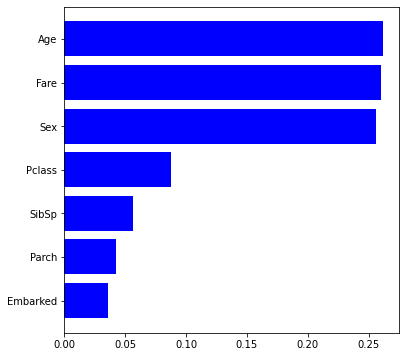

In [ ]:
#変数重要度の可視化
import numpy as np #

features = train_X.columns
importances = clf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(6,6))
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.show()

In [ ]:
# https://www.kaggle.com/sinakhorami/titanic-best-working-classifier

%matplotlib inline
import numpy as np
import pandas as pd
import re as re

train = pd.read_csv('/content/titanic_train.csv', header = 0, dtype={'Age': np.float64})
test  = pd.read_csv('/content/titanic_test.csv' , header = 0, dtype={'Age': np.float64})
full_data = [train, test]

print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [ ]:
# Feature Engineering
# 1. Pclass

print(train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


In [ ]:
# 2. Sex

print(train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean())

      Sex  Survived
0  female  0.742038
1    male  0.188908


In [ ]:
# 3. SibSp and Parch

for dataset in full_data:
  dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

print(train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean())

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


In [ ]:
for dataset in full_data:
  dataset['IsAlone'] = 0
  dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

print(train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean())

   IsAlone  Survived
0        0  0.505650
1        1  0.303538


In [ ]:
# 4. Embarked

for dataset in full_data:
  dataset['Embarked'] = dataset['Embarked'].fillna('S')

print(train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean())

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


In [ ]:
# 5. Fare

for dataset in full_data:
  dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
print(train[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean())

   CategoricalFare  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081


In [ ]:
# 6. Age

for dataset in full_data:
  age_avg 	   = dataset['Age'].mean()
  age_std 	   = dataset['Age'].std()
  age_null_count = dataset['Age'].isnull().sum()
    
  age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
  dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
  dataset['Age'] = dataset['Age'].astype(int)
    
train['CategoricalAge'] = pd.cut(train['Age'], 5)

print(train[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean())

  CategoricalAge  Survived
0  (-0.08, 16.0]  0.530973
1   (16.0, 32.0]  0.370709
2   (32.0, 48.0]  0.340996
3   (48.0, 64.0]  0.434783
4   (64.0, 80.0]  0.090909


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
# 7. Name

def get_title(name):
  title_search = re.search(' ([A-Za-z]+)\.', name)
  # If the title exists, extract and return it.
  if title_search:
    return title_search.group(1)
  return ""

for dataset in full_data:
  dataset['Title'] = dataset['Name'].apply(get_title)

print(pd.crosstab(train['Title'], train['Sex']))

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1


In [ ]:
for dataset in full_data:
  dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
  dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
  dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
  dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

print(train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826


In [ ]:
# Data Cleaning

for dataset in full_data:
  # Mapping Sex
  dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

  # Mapping titles
  title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
  dataset['Title'] = dataset['Title'].map(title_mapping)
  dataset['Title'] = dataset['Title'].fillna(0)
    
  # Mapping Embarked
  dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
  # Mapping Fare
  dataset.loc[ dataset['Fare'] <= 7.91, 'Fare']                                = 0
  dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
  dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']  = 2
  dataset.loc[ dataset['Fare'] > 31, 'Fare']                                   = 3
  dataset['Fare'] = dataset['Fare'].astype(int)
    
  # Mapping Age
  dataset.loc[ dataset['Age'] <= 16, 'Age']                           = 0
  dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
  dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
  dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
  dataset.loc[ dataset['Age'] > 64, 'Age']                            = 4

# Feature Selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'FamilySize']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)

test = test.drop(drop_elements, axis = 1)

print(train.head(10))

train = train.values
test = test.values

   Survived  Pclass  Sex  Age  Fare  Embarked  IsAlone  Title
0         0       3    1    1     0         0        0      1
1         1       1    0    2     3         1        0      3
2         1       3    0    1     1         0        1      2
3         1       1    0    2     3         0        0      3
4         0       3    1    2     1         0        1      1
5         0       3    1    2     1         2        1      1
6         0       1    1    3     3         0        1      1
7         0       3    1    0     2         0        0      4
8         1       3    0    1     1         0        0      3
9         1       2    0    0     2         1        0      3


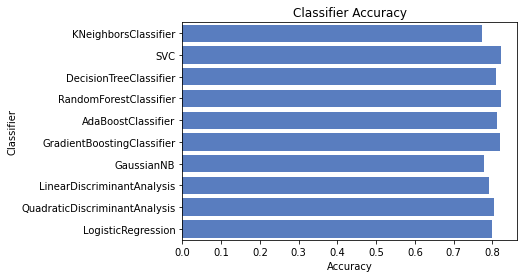

In [ ]:
# Classifier Comparison

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

log_cols = ["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = train[0::, 1::]
y = train[0::, 0]

acc_dict = {}

for train_index, test_index in sss.split(X, y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  for clf in classifiers:
    name = clf.__class__.__name__
    clf.fit(X_train, y_train)
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    if name in acc_dict:
      acc_dict[name] += acc
    else:
      acc_dict[name] = acc

for clf in acc_dict:
  acc_dict[clf] = acc_dict[clf] / 10.0
  log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
  log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

In [ ]:
# Prediction

candidate_classifier = SVC()
candidate_classifier.fit(train[0::, 1::], train[0::, 0])
result = candidate_classifier.predict(test)

In [ ]:
# Python scikit-learnのランダムフォレストで受診予約のNo-Showを予測する
# https://ohke.hateblo.jp/entry/2017/08/04/230000

# ライブラリのインポート
import pandas as pd
import matplotlib.pyplot as pyplot
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import seaborn


# CSVファイルからDataFrameへロード
original_df = pd.read_csv('/content/KaggleV2-May-2016.csv')
original_df.head(6)



,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No
5,9.598513e+13,5626772,F,2016-04-27T08:36:51Z,2016-04-29T00:00:00Z,76,REPÚBLICA,0,1,0,0,0,0,No


###患者の情報
- 年齢(Age)
- 性別(Gender) 
- ハンディキャップ有無(Handcap)
- 奨学金有無(Scholarship)
- アルコール依存(Alcoholism)
- XXX喫煙(Smokes)XXX
- 高血圧(Hipertension)
- 糖尿病(Diabetes)
- XXX結核(Tuberculosis)XXX

###予約の情報
- 予約登録日時(ScheduledDay)
- 予約日(AppointmentDay)
- XXX予約日の曜日(DayOfTheWeek)XXX
- SMSリマインド(SMS_received)
- XXX予約日と予約登録日までの日数(AwaitingTime)XXX

###予約に現れたかどうか : No-show
- 現れた場合は'No'
- 現れなかった場合は'Yes'

In [ ]:
print(original_df.columns)

original_df['No-show'].value_counts() # Status -> No-show

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')


No     88208
Yes    22319
Name: No-show, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f569dec4e48>,
      dtype=object)

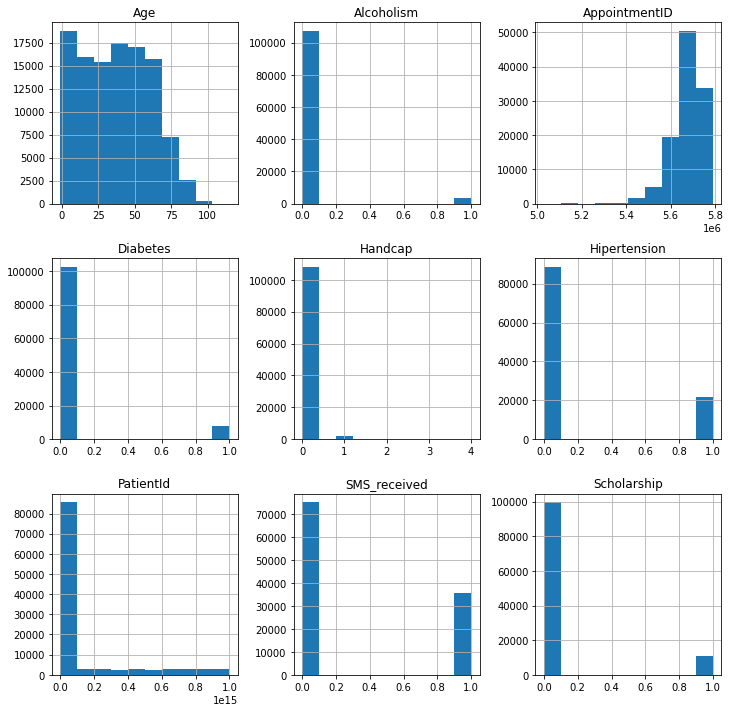

In [ ]:
original_df.hist(figsize=(12, 12))

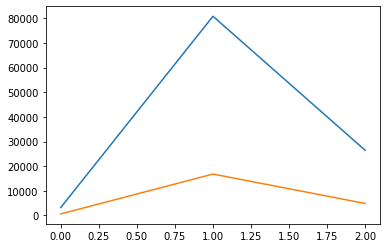

In [ ]:
# 経時的な変化は無いか？ → 現在のデータはそもそも４〜６月しか無い
# AppointmentDate -> AppointmentDay
appointments = pd.DataFrame(index=original_df.index)
appointments['AppointmentDay'] = pd.to_datetime(original_df['AppointmentDay']).apply(lambda a: '{}/{:02}'.format(a.year, a.month))
#appointments['NoShow'] = original_df['Status'].apply(lambda d: 1 if d == 'No-Show' else 0)
appointments['NoShow'] = original_df['No-show'].apply(lambda d: 1 if d == 'Yes' else 0)
temp = pd.DataFrame(appointments.groupby('AppointmentDay').count())
temp['All'] = appointments.groupby('AppointmentDay').count()
#temp['NoShow'] = appointments.groupby('AppointmentDate').sum()
temp['NoShow'] = appointments.groupby('AppointmentDay')['NoShow'].sum()
temp.reset_index(inplace=True)
plt.plot(temp.index, temp['All'])
plt.plot(temp.index, temp['NoShow'])
plt.show()

In [ ]:
print(appointments)
#print(appointments.NoShow)

print(temp)
#print(temp.index)
#print(temp.AppointmentDay)
#print(temp.NoShow)

       AppointmentDay  NoShow
0             2016/04       0
1             2016/04       0
2             2016/04       0
3             2016/04       0
4             2016/04       0
...               ...     ...
110522        2016/06       0
110523        2016/06       0
110524        2016/06       0
110525        2016/06       0
110526        2016/06       0

[110527 rows x 2 columns]
  AppointmentDay  NoShow    All
0        2016/04     633   3235
1        2016/05   16804  80841
2        2016/06    4882  26451


In [ ]:
print(original_df['Gender'])

0         F
1         M
2         F
3         F
4         F
         ..
110522    F
110523    F
110524    F
110525    F
110526    F
Name: Gender, Length: 110527, dtype: object


In [ ]:
#目的変数と説明変数の抽出

features_df = pd.DataFrame()

# 目的変数の抽出(No-Showなら1)
#features_df['Outcome'] = original_df['Status'].apply(lambda s: 1 if s == 'No-Show' else 0)
features_df['Outcome'] = original_df['No-show'].apply(lambda s: 1 if s == 'Yes' else 0)

# 元データを説明変数に追加(typoも同時に修正する)
features_df['Age'] = original_df['Age']
features_df['Male'] = original_df['Gender'].apply(lambda g: 1 if g == 'M' else 0) # 2値変数化
features_df['Diabetes'] = original_df['Diabetes']
features_df['Alcoholism'] = original_df['Alcoholism']
features_df['HiperTension'] = original_df['Hipertension']
features_df['Handicap'] = original_df['Handcap']
features_df['Scholarship'] = original_df['Scholarship']
#features_df['Smokes'] = original_df['Smokes']
features_df['SmsReminder'] = original_df['SMS_received']
#features_df['Tuberculosis'] = original_df['Tuberculosis']
#features_df['AwaitingTime'] = original_df['AwaitingTime']

'''
# 予約日の曜日をone-hot-encoding
d = pd.get_dummies(original_df['DayOfTheWeek'])
features_df['AppointmentMonday'] = d['Monday']
features_df['AppointmentTuesday'] = d['Tuesday']
features_df['AppointmentWednesday'] = d['Wednesday']
features_df['AppointmentThursday'] = d['Thursday']
features_df['AppointmentFriday'] = d['Friday']
features_df['AppointmentSaturday'] = d['Saturday']
features_df['AppointmentSunday'] = d['Sunday']
'''

print(features_df)

        Outcome  Age  Male  ...  Handicap  Scholarship  SmsReminder
0             0   62     0  ...         0            0            0
1             0   56     1  ...         0            0            0
2             0   62     0  ...         0            0            0
3             0    8     0  ...         0            0            0
4             0   56     0  ...         0            0            0
...         ...  ...   ...  ...       ...          ...          ...
110522        0   56     0  ...         0            0            1
110523        0   51     0  ...         0            0            1
110524        0   21     0  ...         0            0            1
110525        0   38     0  ...         0            0            1
110526        0   54     0  ...         0            0            1

[110527 rows x 9 columns]


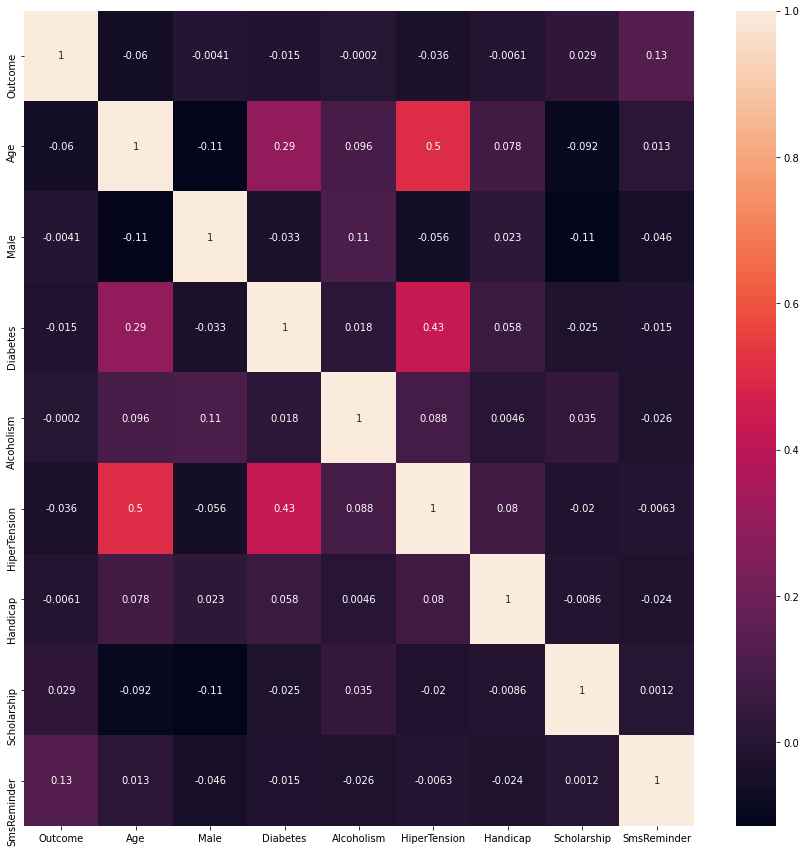

In [ ]:
pyplot.figure(figsize=(15,15))
seaborn.heatmap(features_df.corr(), annot=True)

In [ ]:
# 説明変数と目的変数の分離

# https://qiita.com/junjis0203/items/fbde15dbba5ccdb5dc4c
#X = features_df.ix[:, 'Age':]
X = features_df.loc[:, 'Age':]
y = features_df['Outcome']

# 学習データとテストデータの分離
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# ランダムフォレストの作成
forest = RandomForestClassifier(min_samples_leaf=3, random_state=0)
forest.fit(X_train, y_train)

# 評価
print('Train score: {}'.format(forest.score(X_train, y_train)))
print('Test score: {}'.format(forest.score(X_test, y_test)))
print('Confusion matrix:\n{}'.format(confusion_matrix(y_test, forest.predict(X_test))))
print('f1 score: {:.3f}'.format(f1_score(y_test, forest.predict(X_test))))

Train score: 0.7988660353459195
Test score: 0.800774464389114
Confusion matrix:
[[22080    72]
 [ 5433    47]]
f1 score: 0.017


In [ ]:
'''
regs = pd.to_datetime(original_df['AppointmentRegistration'])
features_df['RegistrationMonday'] = regs.apply(lambda r: 1 if r.date().weekday() == 0 else 0)
features_df['RegistrationTuesday'] = regs.apply(lambda r: 1 if r.date().weekday() == 1 else 0)
features_df['RegistrationWednesday'] = regs.apply(lambda r: 1 if r.date().weekday() == 2 else 0)
features_df['RegistrationThursday'] = regs.apply(lambda r: 1 if r.date().weekday() == 3 else 0)
features_df['RegistrationFriday'] = regs.apply(lambda r: 1 if r.date().weekday() == 4 else 0)
features_df['RegistrationSaturday'] = regs.apply(lambda r: 1 if r.date().weekday() == 5 else 0)
features_df['RegistrationSunday'] = regs.apply(lambda r: 1 if r.date().weekday() == 6 else 0)

features_df['RegistrationWorktime'] = regs.apply(lambda r: 1 if r.hour >= 9 and r.hour < 17 else 0)
'''

([<matplotlib.axis.YTick at 0x7f56a5a49278>,
 [Text(0, 0, 'Diabetes'),
  Text(0, 0, 'Alcoholism'),
  Text(0, 0, 'Male'),
  Text(0, 0, 'Handicap'),
  Text(0, 0, 'Scholarship'),
  Text(0, 0, 'HiperTension'),
  Text(0, 0, 'SmsReminder'),
  Text(0, 0, 'Age')])

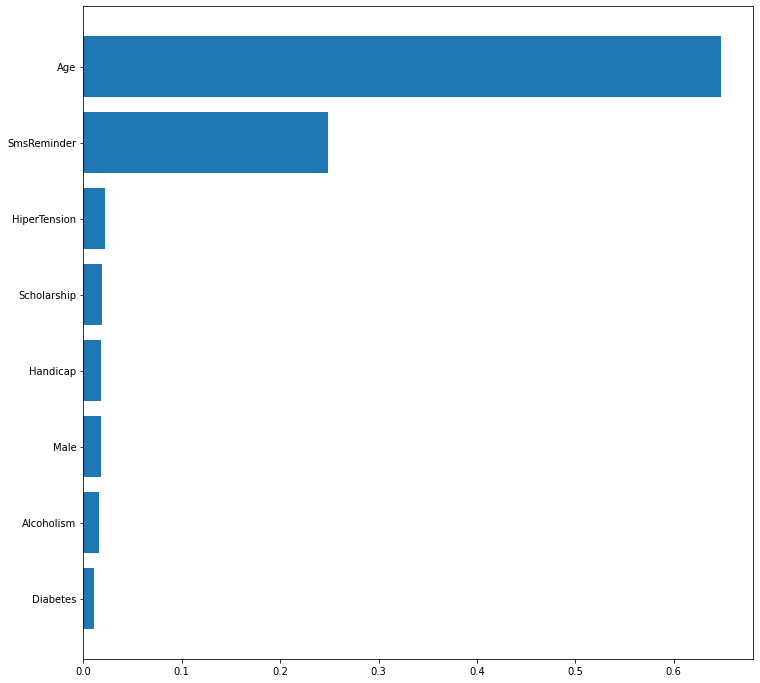

In [ ]:
# RandomForestClassifierは、 feature_importances_ という各説明変数の重要度プロパティを持っている

values, names = zip(*sorted(zip(forest.feature_importances_, X.columns)))

pyplot.figure(figsize=(12,12))
pyplot.barh(range(len(names)), values, align='center')
pyplot.yticks(range(len(names)), names)

In [ ]:
#影響のない変数の削除

#features_df.drop(['RegistrationSunday', 'AppointmentSunday', 'Tuberculosis', 'RegistrationSaturday', 'AppointmentSaturday'], axis=1, inplace=True)

In [ ]:
#ハイパーパラメータの探索

# ハイパーパラメータ
forest_grid_param = {
    'n_estimators': [100],
    'max_features': [1, 'auto', None],
    'max_depth': [1, 5, 10, None],
    'min_samples_leaf': [1, 2, 4,]
}

# スコア方法をF1に設定
f1_scoring = make_scorer(f1_score,  pos_label=1)

# グリッドサーチで学習
forest_grid_search = GridSearchCV(RandomForestClassifier(random_state=0, n_jobs=-1), forest_grid_param, scoring=f1_scoring, cv=4)
forest_grid_search.fit(X_train, y_train)

# 結果
print('Best parameters: {}'.format(forest_grid_search.best_params_))
print('Best score: {:.3f}'.format(forest_grid_search.best_score_))

Best parameters: {'max_depth': None, 'max_features': 1, 'min_samples_leaf': 1, 'n_estimators': 100}
Best score: 0.040


In [ ]:
X2 = features_df.loc[:, 'Age':]
y2 = features_df['Outcome']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=0)

best_params = forest_grid_search.best_params_

forest = RandomForestClassifier(random_state=0, n_jobs=-1, 
                                max_depth=best_params['max_depth'], 
                                max_features=best_params['max_features'], 
                                min_samples_leaf=best_params['min_samples_leaf'],
                                n_estimators=best_params['n_estimators'])
forest.fit(X2_train, y2_train)
print('Train score: {:.3f}'.format(forest.score(X2_train, y2_train)))
print('Test score: {:.3f}'.format(forest.score(X2_test, y2_test)))
print('Confusion matrix:\n{}'.format(confusion_matrix(y2_test, forest.predict(X2_test))))
print('f1 score: {:.3f}'.format(f1_score(y2_test, forest.predict(X2_test))))

Train score: 0.802
Test score: 0.797
Confusion matrix:
[[21949   203]
 [ 5393    87]]
f1 score: 0.030


In [ ]:
#https://www.sejuku.net/blog/64455

from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier as RFC
 
from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:
mnist = datasets.load_digits()
 
train_images, test_images, train_labels, test_labels = \
train_test_split(mnist.data, mnist.target, test_size=0.2) #test_sizeに与えた値がテストデータの割合

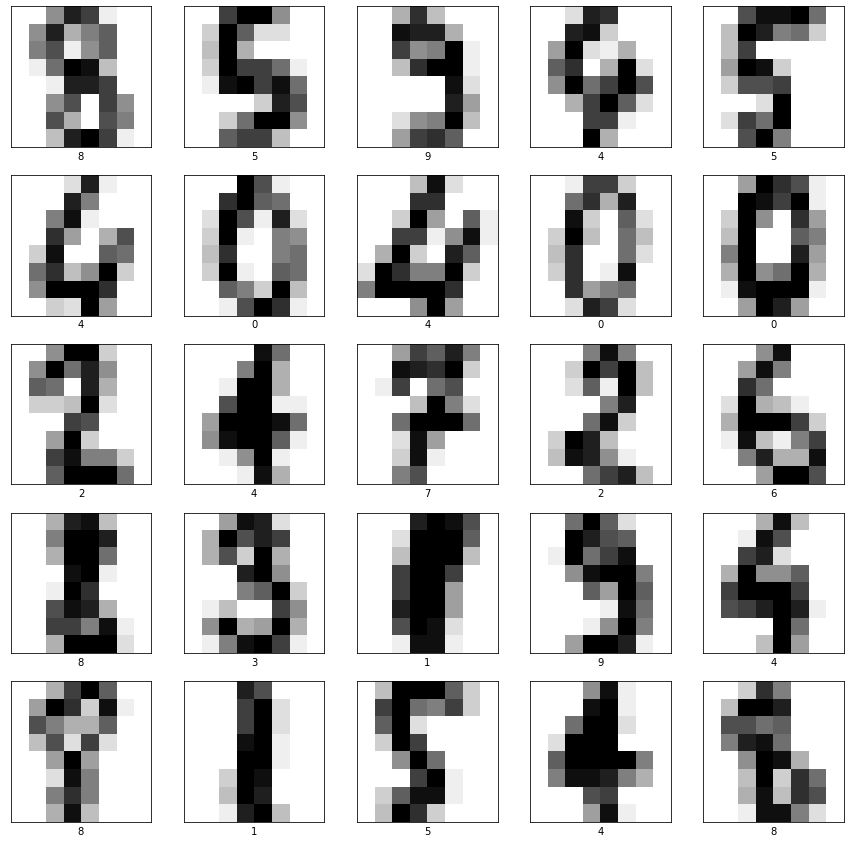

In [ ]:
plt.figure(figsize=(15,15))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(train_images[i].reshape((8,8)), cmap=plt.cm.binary)
  plt.xlabel(train_labels[i])

In [ ]:
clf = RFC(verbose=True,       # 学習中にログを表示します。この指定はなくてもOK
          n_jobs=-1,          # 複数のCPUコアを使って並列に学習します。-1は最大値。
          random_state=2525)  # 乱数のシードです。
clf.fit(train_images, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=2525,
                       verbose=True, warm_start=False)

In [ ]:
print(f"acc: {clf.score(test_images, test_labels)}")

acc: 0.9888888888888889


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


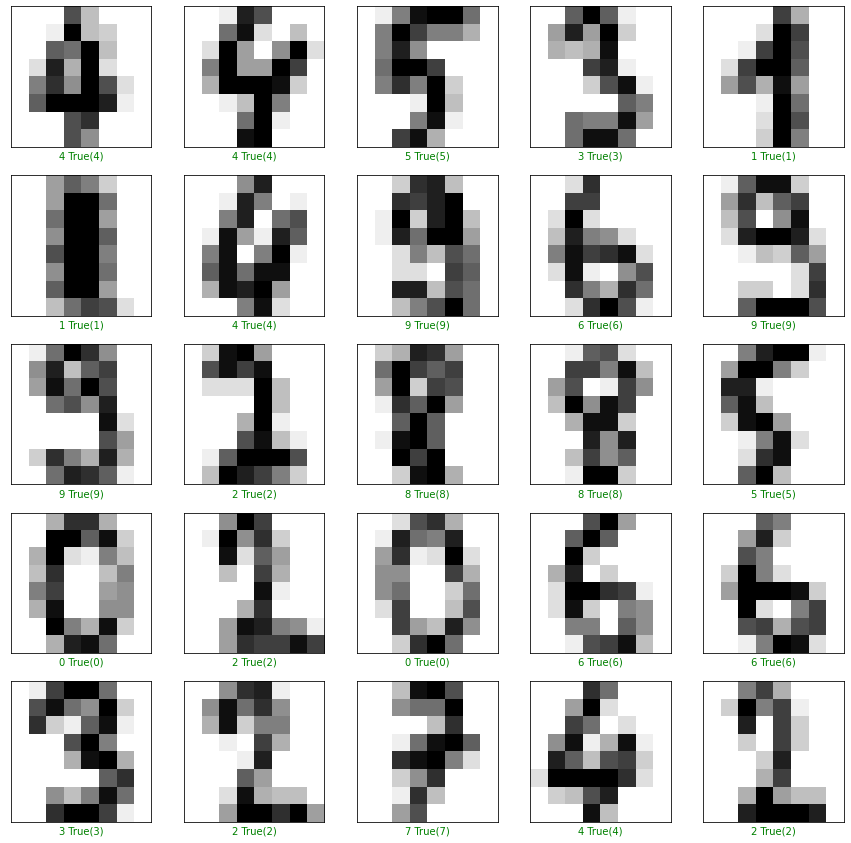

In [ ]:
predicted_labels = clf.predict(test_images)

plt.figure(figsize=(15,15))
 
# 先頭から25枚テストデータを可視化
for i in range(25):
 
  # 画像を作成
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(test_images[i].reshape((8,8)), cmap=plt.cm.binary)
 
  # 今プロットを作っている画像データの予測ラベルと正解ラベルをセット
  predicted_label = predicted_labels[i]
  true_label      = test_labels[i]
 
  # 予測ラベルが正解なら緑、不正解なら赤色を使う
  if predicted_label == true_label:
    color = 'green' # True label color
  else:
    color = 'red'   # False label color
  plt.xlabel("{} True({})".format(predicted_label,
                                  true_label),
                                  color=color)

In [ ]:
search_params = {
    'n_estimators'      : [5, 10, 20, 30, 50, 100, 300],
    'max_features'      : [3, 5, 10, 15, 20],
    'random_state'     : [2525],
    'n_jobs'            : [1],
    'min_samples_split' : [3, 5, 10, 15, 20, 25, 30, 40, 50, 100],
    'max_depth'        : [3, 5, 10, 15, 20, 25, 30, 40, 50, 100]
}

In [ ]:
gs = GridSearchCV(RFC(),          # 対象の機械学習モデル
                  search_params,   # 探索パラメタ辞書
                  cv=3,            # クロスバリデーションの分割数
                  verbose=True,    # ログ表示
                  n_jobs=-1)       # 並列処理
gs.fit(train_images, train_labels)
 
print(gs.best_estimator_)

Fitting 3 folds for each of 3500 candidates, totalling 10500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   56.3s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 4996 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done 6046 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 7196 tasks      | elapsed: 22.2min
[Parallel(n_jobs=-1)]: Done 8446 tasks      | elapsed: 26.4min
[Parallel(n_jobs=-1)]: Done 9796 tasks      | elapsed: 30.3min
[Parallel(n_jobs=-1)]: Done 10500 out of 10500

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
                       oob_score=False, random_state=2525, verbose=0,
                       warm_start=False)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished


acc: 0.9861111111111112


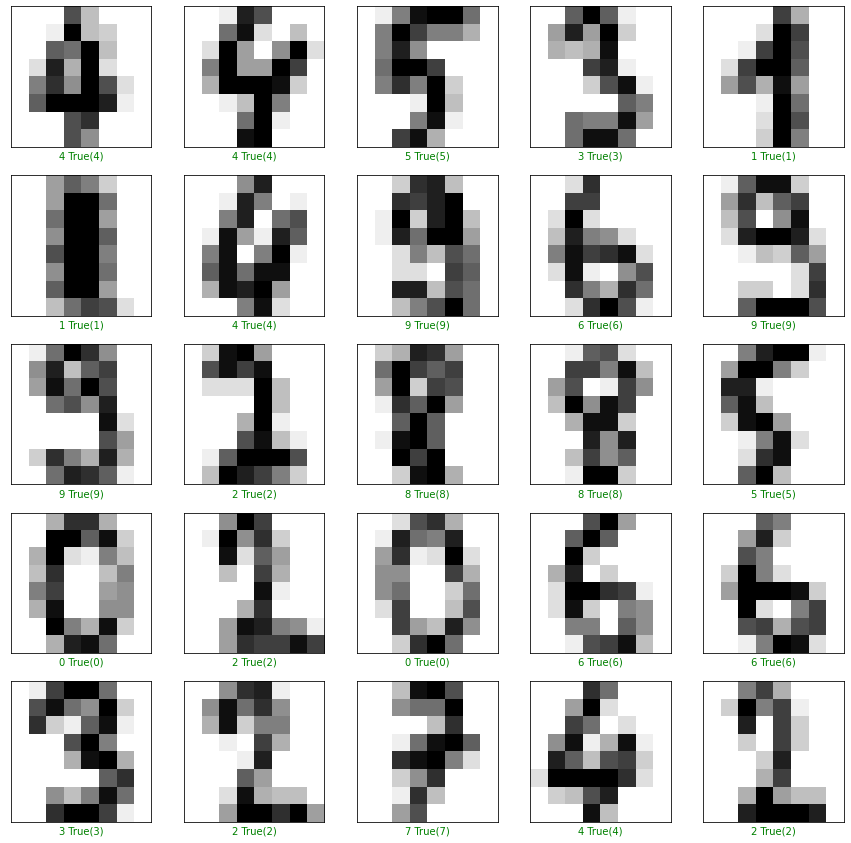

In [ ]:
clf2 = RFC(bootstrap=True, ccp_alpha=0.0, class_weight=None,
           criterion='gini', max_depth=15, max_features=3,
           max_leaf_nodes=None, max_samples=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
           oob_score=False, random_state=2525, verbose=True,
           warm_start=False)
clf2.fit(train_images, train_labels)

print(f"acc: {clf2.score(test_images, test_labels)}")

predicted_labels = clf2.predict(test_images)

plt.figure(figsize=(15,15))
 
# 先頭から25枚テストデータを可視化
for i in range(25):
 
  # 画像を作成
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(test_images[i].reshape((8,8)), cmap=plt.cm.binary)
 
  # 今プロットを作っている画像データの予測ラベルと正解ラベルをセット
  predicted_label = predicted_labels[i]
  true_label      = test_labels[i]
 
  # 予測ラベルが正解なら緑、不正解なら赤色を使う
  if predicted_label == true_label:
    color = 'green' # True label color
  else:
    color = 'red'   # False label color
  plt.xlabel("{} True({})".format(predicted_label,
                                  true_label),
                                  color=color)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=4,
                           n_informative=2, n_redundant=0,
                           random_state=0, shuffle=False)
clf3 = RandomForestClassifier(max_depth=2, random_state=0)
clf3.fit(X, y)

print(clf3.feature_importances_)

print(clf3.predict([[0, 0, 0, 0]]))


[0.14205973 0.76664038 0.0282433  0.06305659]
[1]


In [ ]:
#決定木の分類結果を可視化する関数

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
  #setup marker generator and color map
  markers = ('s', 'x', 'o', '^', 'v')
  colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
  cmap = ListedColormap(colors[:len(np.unique(y))])

  # plot the decision surface
  # 最小値, 最大値からエリアの領域を割り出す
  x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  # resolutionの間隔で区切った領域を定義
  xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                         np.arange(x2_min, x2_max, resolution))
  # print(xx1.shape)
  
  Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
  Z = Z.reshape(xx1.shape)
  plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
  plt.xlim(xx1.min(), xx1.max())
  plt.ylim(xx2.min(), xx2.max())

  # plot all samples
  X_test, y_test = X[test_idx, :], y[test_idx]
  for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                alpha=0.8, c=cmap(idx),
                marker=markers[idx], label=cl)
    
    # highlight test samples
    if test_idx:
      X_test, y_test = X[test_idx, :], y[test_idx]
      plt.scatter(X_test[:, 0], X_test[:, 1], c='',
                  alpha=1.0, linewidth=1, marker='o',
                  s=55, label='test set')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


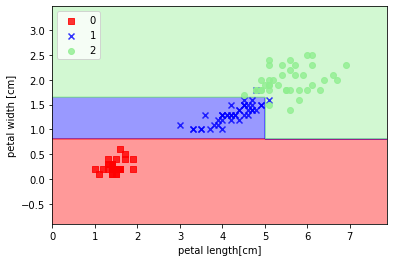

In [ ]:
#irisデータで　DecisionTreeClassifier　を利用した分類例

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split # cross_validation -> model_selection

# データを読み込み
from sklearn.datasets import load_iris
iris = load_iris()

# 説明変数 (それぞれ、がく片や花弁の幅、長さを示します)
# irisのデータセットの第3, 4カラム
x = iris.data[:, [2, 3]]
# 目的変数 (0, 1, 2 がそれぞれの品種を表します)
# irisのそれぞれのデータごとのラベル
y = iris.target

# データセットを訓練データとテストデータに分割
# 今はtest_size=0.3なので訓練データ7割テストデータ3割にしている
# sklearn.model_selection.train_test_split 
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

x_combined = np.vstack((x_train, x_test))
y_combined = np.hstack((y_train, y_test))

# エントロピーを指標とする決定木のインスタンスを生成
tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
tree.fit(x_train, y_train)

plot_decision_regions(x_train, y_train, classifier=tree)
plt.xlabel('petal length[cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


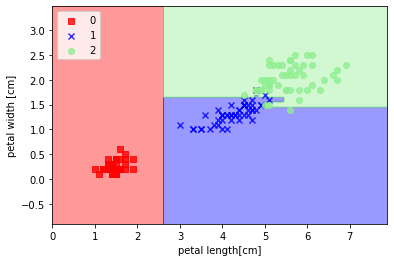

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# エントロピーを指標とするランダムフォレストのインスタンス生成
forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=10, random_state=1, n_jobs=2)
# n_jobs=2 -> CPU コアを2つ使用して並列処理
# n_estimators=10 -> 10個の決定木からランダムフォレストをトレーニング
# 

# ランダムフォレストのモデルにトレーニングデータを適合させる
forest.fit(x_train, y_train)
plot_decision_regions(x_combined, y_combined, classifier=forest)
plt.xlabel('petal length[cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.show()

In [ ]:
from xgboost import XGBClassifier

classifier = XGBClassifier()
classifier.fit(X_train, y_train)

#XGBClassifier(base_score=0.5, booster='gbtree', #colsample_bylevel=1,
#       colsample_bytree=1, gamma=0, learning_rate=0.1, #max_delta_step=0,
#       max_depth=3, min_child_weight=1, missing=None, #n_estimators=100,
#       n_jobs=1, nthread=None, objective='binary:logistic', #random_state=0,
#       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, #seed=None,
#       silent=True, subsample=1)

XGBoostError: ignored